In [13]:
import os
import numpy as np

from itertools import product
from collections import defaultdict

import itertools

import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

import mpl_toolkits.axisartist as axisartist
# import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
from matplotlib.colors import PowerNorm

from matplotlib.colors import ListedColormap

# %matplotlib widget
%matplotlib inline

os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR'] = 'False'
matplotlib.rcParams['font.family'] = 'monospace'

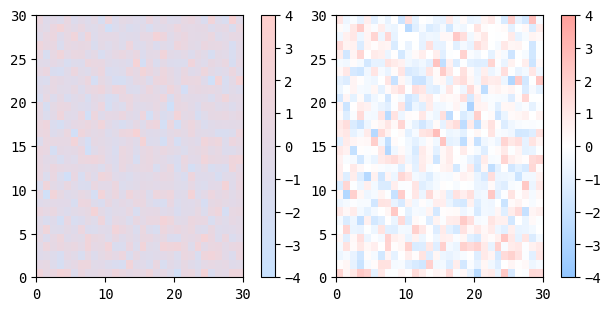

In [14]:
colors = list()
# with plt.style.context("default"):
with plt.style.context("seaborn-v0_8-pastel"):
    for i, color in enumerate(plt.rcParams['axes.prop_cycle']):
        colors.append(color['color'])
i, j = 1, 0
i, j = 2, 0
d = 256

v = np.ones((d, 4))
for ch in range(3):
    v[:, ch] = np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d)/2 \
               + np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)/2
seq_cmap = ListedColormap(v)

d = 128
v_up = np.ones((d, 4))
v_bot = np.ones((d, 4))
for ch in range(3):
    v_up[:, ch] = np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)
    v_bot[:, ch] = np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d)
div_cmap = ListedColormap(np.vstack((v_up, v_bot)))


def plot_examples(colormaps):
    np.random.seed(0)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()


plot_examples([seq_cmap, div_cmap])

In [15]:
class FirstElementHashable(tuple):
    def __eq__(self, comp):
        return self[0] == comp[0]

    def __ne__(self, comp):
        return self[0] != comp[0]

    def __hash__(self):
        return hash((self[0],))


def params_dict_to_string(d):
    st = list()
    for k, v in d.items():
        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        else:
            if k[-1] == "_":
                k = k[:-1]
            v = str(v)#.replace('{', '(').replace('}', ')')
            st.append(f"{k}={v}")

    st = ', '.join(st)
    return st


def title_from_dict(d):
    st = list()
    for k, v in d.items():
        # if k not in ya_keys:
        #     continue

        # if k[-1] == '_':
        #     k = k[:-1]

        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        elif isinstance(v, set):
            # print(v)
            for i in v:
                if i is not None:
                    break
            # v = str(i).replace('{', '(').replace('}', ')')
            st.append(f"{k}={i}")
        else:
            st.append(f"{k}={str(v)}")

    st = ', '.join(st)
    return st

In [16]:
tracking_uri = os.path.expanduser('~/mlruns/')
experiment_name = os.path.basename(os.getcwd())
experiment_name

'MeritFed-N'

In [17]:
experiment_name = 'MeritFed-N'

In [18]:
markers = ['^', '<', '>', 'v', 'o', 's', 'D', '*']

{'md_n_iters_': [{None, 20}], 'md_lr_': [{0.01, None}]}
{"{'n_peers': 20, 'model': {'name': 'Net', 'id': 2}, 'loss': {'name': 'CrossEntropy', 'id': 1}, 'dataset': {'name': 'MNIST', 'id': 1}, 'n_samples': 200, 'h_ratio': 0.99, 'batch_size': 20, 'lr': 0.01}"}
1
1
1
2


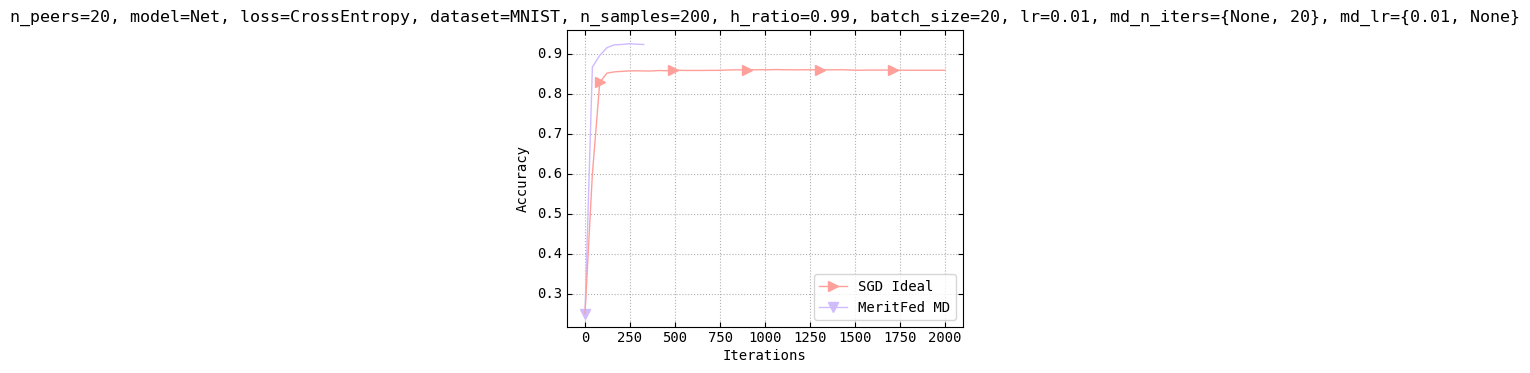

In [30]:
label_keys = ['optimizer', 'md_full_', 'true_weights']
one_plot = ['seed', 'n_iters']
# ya_keys = ['md_n_iters_', 'md_lr_']
metric_key = 'accuracy'
# metric_key = 'loss-full'
# metric_key = 'loss'


client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)
run_configs = list()
ya_dict = dict()  # contains parameters which can be None for some runs
label_keys_dict = dict()
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json', )
    run_configs.append(config)

    for k in config:
        if k in label_keys or k in one_plot:
        # if k in label_keys or k == 'seed':
            if not isinstance(config[k], dict):
                if k not in label_keys_dict:
                    label_keys_dict.update({k: {config[k]}})
                else:
                    label_keys_dict[k].add(config[k])

        if k[-1] == '_' and k not in label_keys:
            if k not in ya_dict:
                ya_dict.update({k: {config[k]}})
            else:
                ya_dict[k].add(config[k])
ya_dict
ya_keys = ya_dict.keys()
ya_keys

ya_set_valued_dict = dict()
for k, v in ya_dict.items():
    non_none_values = list()
    for i in v:
        if i is not None:
            non_none_values.append({None, i})
    # if non_none_values:
    ya_set_valued_dict.update({k: non_none_values})
print(ya_set_valued_dict)

keys, values = zip(*ya_set_valued_dict.items())
ya_list = [dict(zip(keys, v)) for v in itertools.product(*values)]
ya_list

label_key_id_lookup = {k: {i: val for val, i in enumerate(label_keys_dict[k])}
                 for k in label_keys_dict if k != 'seed'}
label_key_id_lookup  # rename id lookup
label_key_id_lookup = {'true_weights': {False: 1, True: 2, None: 0},
                       'md_full_': {None: 1, True: 2, False: 0}}

sparse_run_configs = []
params_set = set()
for i, r in enumerate(runs):
    config = run_configs[i]

    sparse_run_configs.append(dict())

    for k, v in config.items():
        if k in label_keys or k in ya_keys or k in one_plot:
            continue

        if v is not None:
            sparse_run_configs[-1].update({k: v})

    params_set.add(str(sparse_run_configs[-1]))
print(params_set)

params_list = list()
for p in params_set:
    d = eval(p)
    for k in d.keys():
        if isinstance(v, str):
            d[k] = eval(d[k])
        else:
            d[k] = d[k]
    # print(d)

    for ya_d in ya_list:
        for k, v in ya_d.items():
            d.update({k: v})
        params_list.append(d.copy())
    # if str(d) == p:  # if d not changed
    #     params_list.append(d.copy())

print(len(params_list))
params_list


def params_in_config(params, config):
    # for k in ya_keys:
    #     if config[k] == None:
    #         return True

    for k in params:
        # if k == 'n_iters':
        #     continue
        if k in ya_keys:
            if config[k] not in params[k]:
                return False
        else:
            if config[k] != params[k]:
                return False

    return True


runs_sets = [set() for _ in params_list]
for i, r in enumerate(runs):
    config = run_configs[i]
    for j, params in enumerate(params_list):
        if params_in_config(params, config):
            runs_sets[j].add(FirstElementHashable((r, config)))
# print(runs_sets)
for i, run_set in enumerate(runs_sets):
    flag = False
    for _, config in run_set:
        for k in ya_keys:
            if config[k] is not None:
                flag = True
    if not flag:
    # if not flag and not ya_keys:
        runs_sets[i] = None
        params_list[i] = None

print(len(runs_sets))
params_list
runs_sets_list = [s for s in runs_sets if s is not None]
params_list = [i for i in params_list if i is not None]
print(len(runs_sets_list))
# print(runs_sets_list)

for i, runs in enumerate(runs_sets_list):
    print(len(runs))
    if len(runs) < 1:
        continue
    title = params_dict_to_string(params_list[i])
    # title = title_from_dict(params_list[i])
    # print(title)
    for k in one_plot:
        if k in params_list[i]:
            params_list[i].pop(k)

#     if 'seed' in params_list[i]:
#         params_list[i].pop('seed')
    fig = plt.figure(figsize=(4, 3))
    # fig = plt.figure(figsize=(9, 6))
    ax = fig.add_axes([0.01, 0.01, 0.99, 0.99], axes_class=axisartist.Axes)

    for j, (r, config) in enumerate(runs):
        beg = 0
        end = 20000

        label = list()
        for k in label_keys:
            if isinstance(config[k], dict):
                name = config[k]['name']
                if name == 'SGDMD':
                    label.append('MeritFed')
                else:
                    label.append(name)
            else:
                if config[k] is not None:
                    # if k[-1] == '_':
                    #     name = k[:-1]
                    # else:
                    #     name = k
                    # label.append(name + '=' + str(config[k]))
                    if k == 'md_full_':
                        if config[k] == True:
                            name = 'MD'
                        else:
                            name = 'SMD'
                        label.append(name)
                    if k == 'true_weights':
                        if config[k] == True:
                            name = 'Ideal'
                        else:
                            name = 'Full'
                        label.append(name)
        label = ' '.join(label)

        for idx, k in enumerate(label_keys):
            if isinstance(config[k], dict):
                id = config[k]['id']

        label_key_id_lookup = {'true_weights': {False: 1, True: 2, None: 0},
                     'md_full_': {None: 1, True: 3, False: 0}}

        for idx, k in enumerate(label_keys):
            if isinstance(config[k], dict):
                continue
            else:
                # id += 1*(idx-1) + label_key_id_lookup[k][config[k]] - 1
                id += 2*(idx-1) + label_key_id_lookup[k][config[k]] - 1
        id -= 1
        # print(id)
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        ax.plot(x, y,
                alpha=1,
                color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(x), 10), markersize=7,
                label=label, linewidth=1)

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by, labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
    ax.legend(handles, labels)

    ax.axis["left"].major_ticklabels.set_ha("left")
    # ax.set_title(title)
    ax.set_xlabel('Iterations')
    # ax.set_ylabel(params_list[i]['loss']['name'])
    ax.set_ylabel(r'Accuracy')
    # ax.set_yscale('log')
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) # 2 decimal places
    # ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2e')) # 2 decimal places
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls='dotted')
    # ax.legend(loc='center right')

    # plt.tight_layout()
    # name = params_dict_to_string(params_list[i])
    name = 'acc ' + title_from_dict(params_list[i])
    name = name.replace('_', '')
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    # plt.savefig(name +'.pdf', bbox_inches='tight')
    # fig.subplots_adjust(wspace=0.3, hspace=0.3)
    # fig.suptitle(title, wrap = True),
    plt.title(title)
    fig.show()
    # break~

In [31]:
def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

{'md_n_iters_': [{None, 20}], 'md_lr_': [{0.01, None}]}
{"{'n_peers': 20, 'model': {'name': 'Net', 'id': 2}, 'loss': {'name': 'CrossEntropy', 'id': 1}, 'dataset': {'name': 'MNIST', 'id': 1}, 'n_samples': 200, 'h_ratio': 0.99, 'batch_size': 20, 'lr': 0.01}"}
1
1
1
2


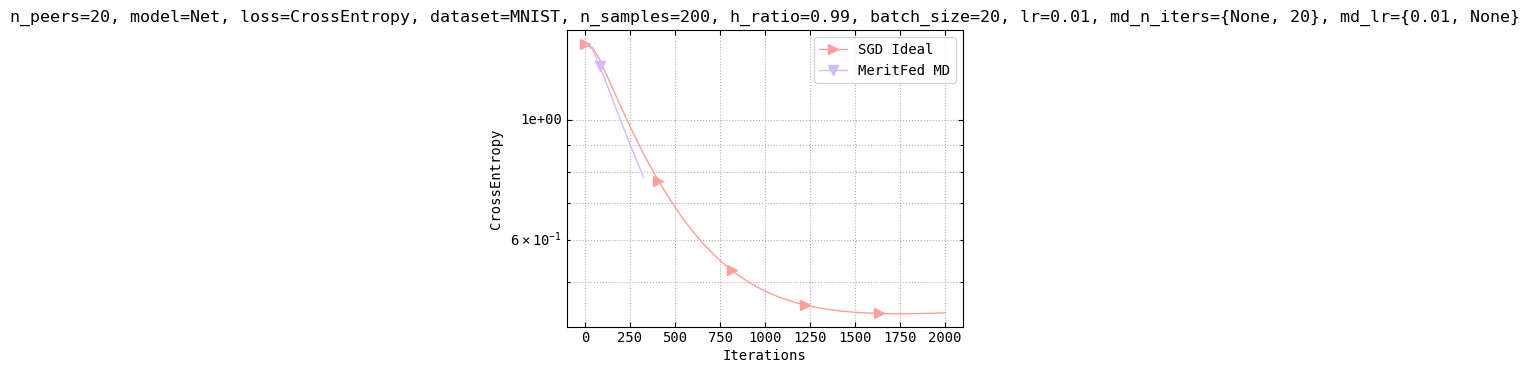

In [32]:
label_keys = ['optimizer', 'md_full_', 'true_weights']
one_plot = ['seed', 'n_iters']
# ya_keys = ['md_n_iters_', 'md_lr_']
metric_key = 'accuracy'
metric_key = 'loss-full'
# metric_key = 'loss'


client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)
run_configs = list()
ya_dict = dict()  # contains parameters which can be None for some runs
label_keys_dict = dict()
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json', )
    run_configs.append(config)

    for k in config:
        if k in label_keys or k in one_plot:
        # if k in label_keys or k == 'seed':
            if not isinstance(config[k], dict):
                if k not in label_keys_dict:
                    label_keys_dict.update({k: {config[k]}})
                else:
                    label_keys_dict[k].add(config[k])

        if k[-1] == '_' and k not in label_keys:
            if k not in ya_dict:
                ya_dict.update({k: {config[k]}})
            else:
                ya_dict[k].add(config[k])
ya_dict
ya_keys = ya_dict.keys()
ya_keys

ya_set_valued_dict = dict()
for k, v in ya_dict.items():
    non_none_values = list()
    for i in v:
        if i is not None:
            non_none_values.append({None, i})
    # if non_none_values:
    ya_set_valued_dict.update({k: non_none_values})
print(ya_set_valued_dict)

keys, values = zip(*ya_set_valued_dict.items())
ya_list = [dict(zip(keys, v)) for v in itertools.product(*values)]
ya_list

label_key_id_lookup = {k: {i: val for val, i in enumerate(label_keys_dict[k])}
                 for k in label_keys_dict if k != 'seed'}
label_key_id_lookup  # rename id lookup
label_key_id_lookup = {'true_weights': {False: 1, True: 2, None: 0},
                       'md_full_': {None: 1, True: 2, False: 0}}

sparse_run_configs = []
params_set = set()
for i, r in enumerate(runs):
    config = run_configs[i]

    sparse_run_configs.append(dict())

    for k, v in config.items():
        if k in label_keys or k in ya_keys or k in one_plot:
            continue

        if v is not None:
            sparse_run_configs[-1].update({k: v})

    params_set.add(str(sparse_run_configs[-1]))
print(params_set)

params_list = list()
for p in params_set:
    d = eval(p)
    for k in d.keys():
        if isinstance(v, str):
            d[k] = eval(d[k])
        else:
            d[k] = d[k]
    # print(d)

    for ya_d in ya_list:
        for k, v in ya_d.items():
            d.update({k: v})
        params_list.append(d.copy())
    # if str(d) == p:  # if d not changed
    #     params_list.append(d.copy())

print(len(params_list))
params_list


def params_in_config(params, config):
    # for k in ya_keys:
    #     if config[k] == None:
    #         return True

    for k in params:
        # if k == 'n_iters':
        #     continue
        if k in ya_keys:
            if config[k] not in params[k]:
                return False
        else:
            if config[k] != params[k]:
                return False

    return True


runs_sets = [set() for _ in params_list]
for i, r in enumerate(runs):
    config = run_configs[i]
    for j, params in enumerate(params_list):
        if params_in_config(params, config):
            runs_sets[j].add(FirstElementHashable((r, config)))
# print(runs_sets)
for i, run_set in enumerate(runs_sets):
    flag = False
    for _, config in run_set:
        for k in ya_keys:
            if config[k] is not None:
                flag = True
    if not flag:
    # if not flag and not ya_keys:
        runs_sets[i] = None
        params_list[i] = None

print(len(runs_sets))
params_list
runs_sets_list = [s for s in runs_sets if s is not None]
params_list = [i for i in params_list if i is not None]
print(len(runs_sets_list))
# print(runs_sets_list)

for i, runs in enumerate(runs_sets_list):
    print(len(runs))
    if len(runs) < 1:
        continue
    title = params_dict_to_string(params_list[i])
    # title = title_from_dict(params_list[i])
    # print(title)
    for k in one_plot:
        if k in params_list[i]:
            params_list[i].pop(k)

#     if 'seed' in params_list[i]:
#         params_list[i].pop('seed')
    fig = plt.figure(figsize=(4, 3))
    # fig = plt.figure(figsize=(9, 6))
    ax = fig.add_axes([0.01, 0.01, 0.99, 0.99], axes_class=axisartist.Axes)

    for j, (r, config) in enumerate(runs):
        beg = 0
        end = 20000

        label = list()
        for k in label_keys:
            if isinstance(config[k], dict):
                name = config[k]['name']
                if name == 'SGDMD':
                    label.append('MeritFed')
                else:
                    label.append(name)
            else:
                if config[k] is not None:
                    # if k[-1] == '_':
                    #     name = k[:-1]
                    # else:
                    #     name = k
                    # label.append(name + '=' + str(config[k]))
                    if k == 'md_full_':
                        if config[k] == True:
                            name = 'MD'
                        else:
                            name = 'SMD'
                        label.append(name)
                    if k == 'true_weights':
                        if config[k] == True:
                            name = 'Ideal'
                        else:
                            name = 'Full'
                        label.append(name)
        label = ' '.join(label)

        for idx, k in enumerate(label_keys):
            if isinstance(config[k], dict):
                id = config[k]['id']

        label_key_id_lookup = {'true_weights': {False: 1, True: 2, None: 0},
                     'md_full_': {None: 1, True: 3, False: 0}}

        for idx, k in enumerate(label_keys):
            if isinstance(config[k], dict):
                continue
            else:
                # id += 1*(idx-1) + label_key_id_lookup[k][config[k]] - 1
                id += 2*(idx-1) + label_key_id_lookup[k][config[k]] - 1
        id -= 1
        # print(id)
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        y = smooth(y, 0.9)

        ax.plot(x, y,
                alpha=1,
                color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(x), 10), markersize=7,
                label=label, linewidth=1)

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by, labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
    ax.legend(handles, labels)

    ax.axis["left"].major_ticklabels.set_ha("left")
    # ax.set_title(title)
    ax.set_xlabel('Iterations')
    ax.set_ylabel(params_list[i]['loss']['name'])
    # ax.set_ylabel(r'$\mathbb{E} f - f^*$')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) # 2 decimal places
    # ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2e')) # 2 decimal places
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls='dotted')
    # ax.legend(loc='center right')

    # plt.tight_layout()
    # name = params_dict_to_string(params_list[i])
    name = 'test ' + title_from_dict(params_list[i])
    name = name.replace('_', '')
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    # plt.savefig(name +'.pdf', bbox_inches='tight')
    # fig.subplots_adjust(wspace=0.3, hspace=0.3)
    # fig.suptitle(title, wrap = True),
    plt.title(title)
    fig.show()
    # break

w npeers=20, model=Net, loss=CrossEntropy, dataset=MNIST, nsamples=200, hratio=0.99, batchsize=20, lr=0.01, mdniters=20, mdlr=0.01


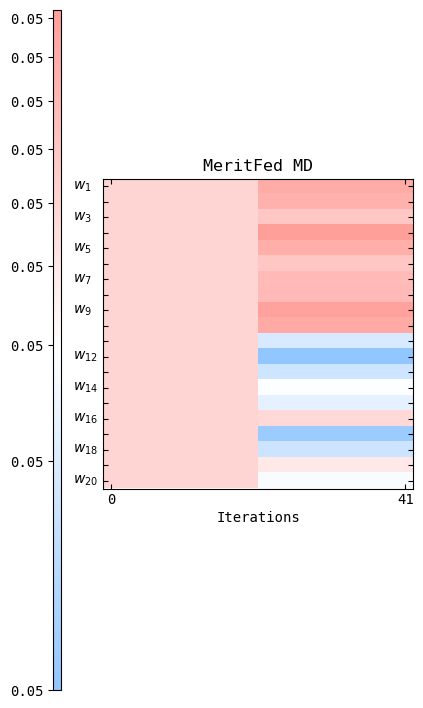

In [24]:
for i, runs in enumerate(runs_sets_list):
    if len(runs) < 1:
        continue
    ttitle = params_dict_to_string(params_list[i])
    # print(title)
    if 'seed' in params_list[i]:
        params_list[i].pop('seed')
    count = 0
    for j, (r, config) in enumerate(runs):
        if config['md_full_'] is not None:
            count += 1

    if count == 0:
        continue
    fig = plt.figure(figsize=(4,8))
    # gs = GridSpec(nrows=1, ncols=count, width_ratios=[1, 1])
    # gs = GridSpec(nrows=1, ncols=count)
    gs = GridSpec(nrows=count, ncols=1)
    axs = list()
    for j in range(count):
        # axs.append(fig.add_subplot(gs[0, j]))
        # axs.append(fig.add_subplot(gs[0, j], axes_class=axisartist.Axes))
        axs.append(fig.add_subplot(gs[j, 0], axes_class=axisartist.Axes))

    min_w, max_w = 1., 0.
    count = 0
    weights = []
    for j, (r, config) in enumerate(runs):
        if config['md_n_iters_'] is None:
            continue
        for rank in range(config['n_peers']):
            k = 'weights_%s' % (str(rank))
            history = client.get_metric_history(run_id=r.info.run_id, key=k)
            y = np.array([h.value for h in history])
            weights.append(y.min())
            weights.append(y.max())
    weights = np.array(weights)

    min_w = min(min_w, weights.min())
    max_w = max(max_w, weights.max())

    count = 0
    im = None
    for j, (r, config) in enumerate(runs):
        if config['md_n_iters_'] is not None:
            weights = []
            labels = list()
            y_ticks_map = np.linspace(0, config['n_peers']-1, 10, endpoint=True).round().astype(int)

            for rank in range(config['n_peers']):
                k = 'weights_%s' % (str(rank))
                if rank in y_ticks_map:
                    labels.append(r'$  w_{%s}$' % (str(rank+1)))
                else:
                    labels.append('')

                history = client.get_metric_history(run_id=r.info.run_id, key=k)
                y = np.array([h.value for h in history])
                x = np.array([h.step for h in history])
                ticks_map = np.linspace(0, len(y)-1, config['n_peers'], endpoint=True).round().astype(int)
                y = [y[j] for j in ticks_map]
                weights.append(y)
            weights = np.array(weights)  # .copy()

            title = list()
            for k in label_keys:
                if isinstance(config[k], dict):
                    title.append(config[k]['name'])
                else:
                    if config[k] is not None:
                        # if k[-1] == '_':
                        #     title.append(k[:-1] + '=' + str(config[k]))
                        if k == 'md_full_':
                            if config[k] is True:
                                name = 'MD'
                            else:
                                name = 'SMD'
                            title.append(name)
            title = ' '.join(title)
            axs[count].set_title(title)
 
            im = axs[count].matshow(weights, cmap=div_cmap, norm=PowerNorm(gamma=1. / 2.3))
            # im = axs[count].matshow(weights, cmap=div_cmap, norm=LogNorm(vmin=min_w, vmax=max_w))
            # im = axs[count].imshow(weights, cmap=div_cmap, vmin=min_w, vmax=max_w)
            axs[count].set_xlabel('Iterations')
            axs[count].set_xticks([0, len(ticks_map)-1])
            axs[count].set_xticklabels(['0', str(x[-1])])

            axs[count].axis["left"].major_ticklabels.set_ha("left")
            # if not count:
            #     axs[count].set_yticks(np.arange(len(labels)), labels=labels)
            # else:
            #     axs[count].set_yticks([])
            axs[count].set_yticks(np.arange(len(labels)), labels=labels)
            count += 1

    cbar_ax = fig.add_axes([0., 0.05, .02, 0.85])
    cb = fig.colorbar(im, cax=cbar_ax, location='left', format=mtick.FormatStrFormatter('%.2f'))

    # print(title)
    # plt.tight_layout()
    name = 'w ' + title_from_dict(params_list[i])
    name = name.replace('_', '')
    print(name)
    fig.subplots_adjust(hspace=.4)
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    # plt.savefig('figures/'+ name +'.pdf')
    # plt.savefig('figures/'+ name +'.pdf')
    # plt.savefig(title +'.pdf', bbox_inches='tight')
    # fig.subplots_adjust(wspace=0.05, left = 0.23)
    # fig.suptitle(title, wrap = True)
    # plt.title(ttitle)
    fig.show()
    # break